In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.linear_model import LogisticRegression
from itertools import chain, combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from my_functions import powerset
from my_functions import get_mult_corr_p

Выборка: Wine.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

In [2]:
data = load_wine()
features = data.feature_names
df = pd.DataFrame(np.hstack((data.data, data.target.reshape(-1, 1))),
                  columns=features + ['target'])
features = np.array(features)

In [3]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


Все признаки вещественные, целевая переменная - категориальная

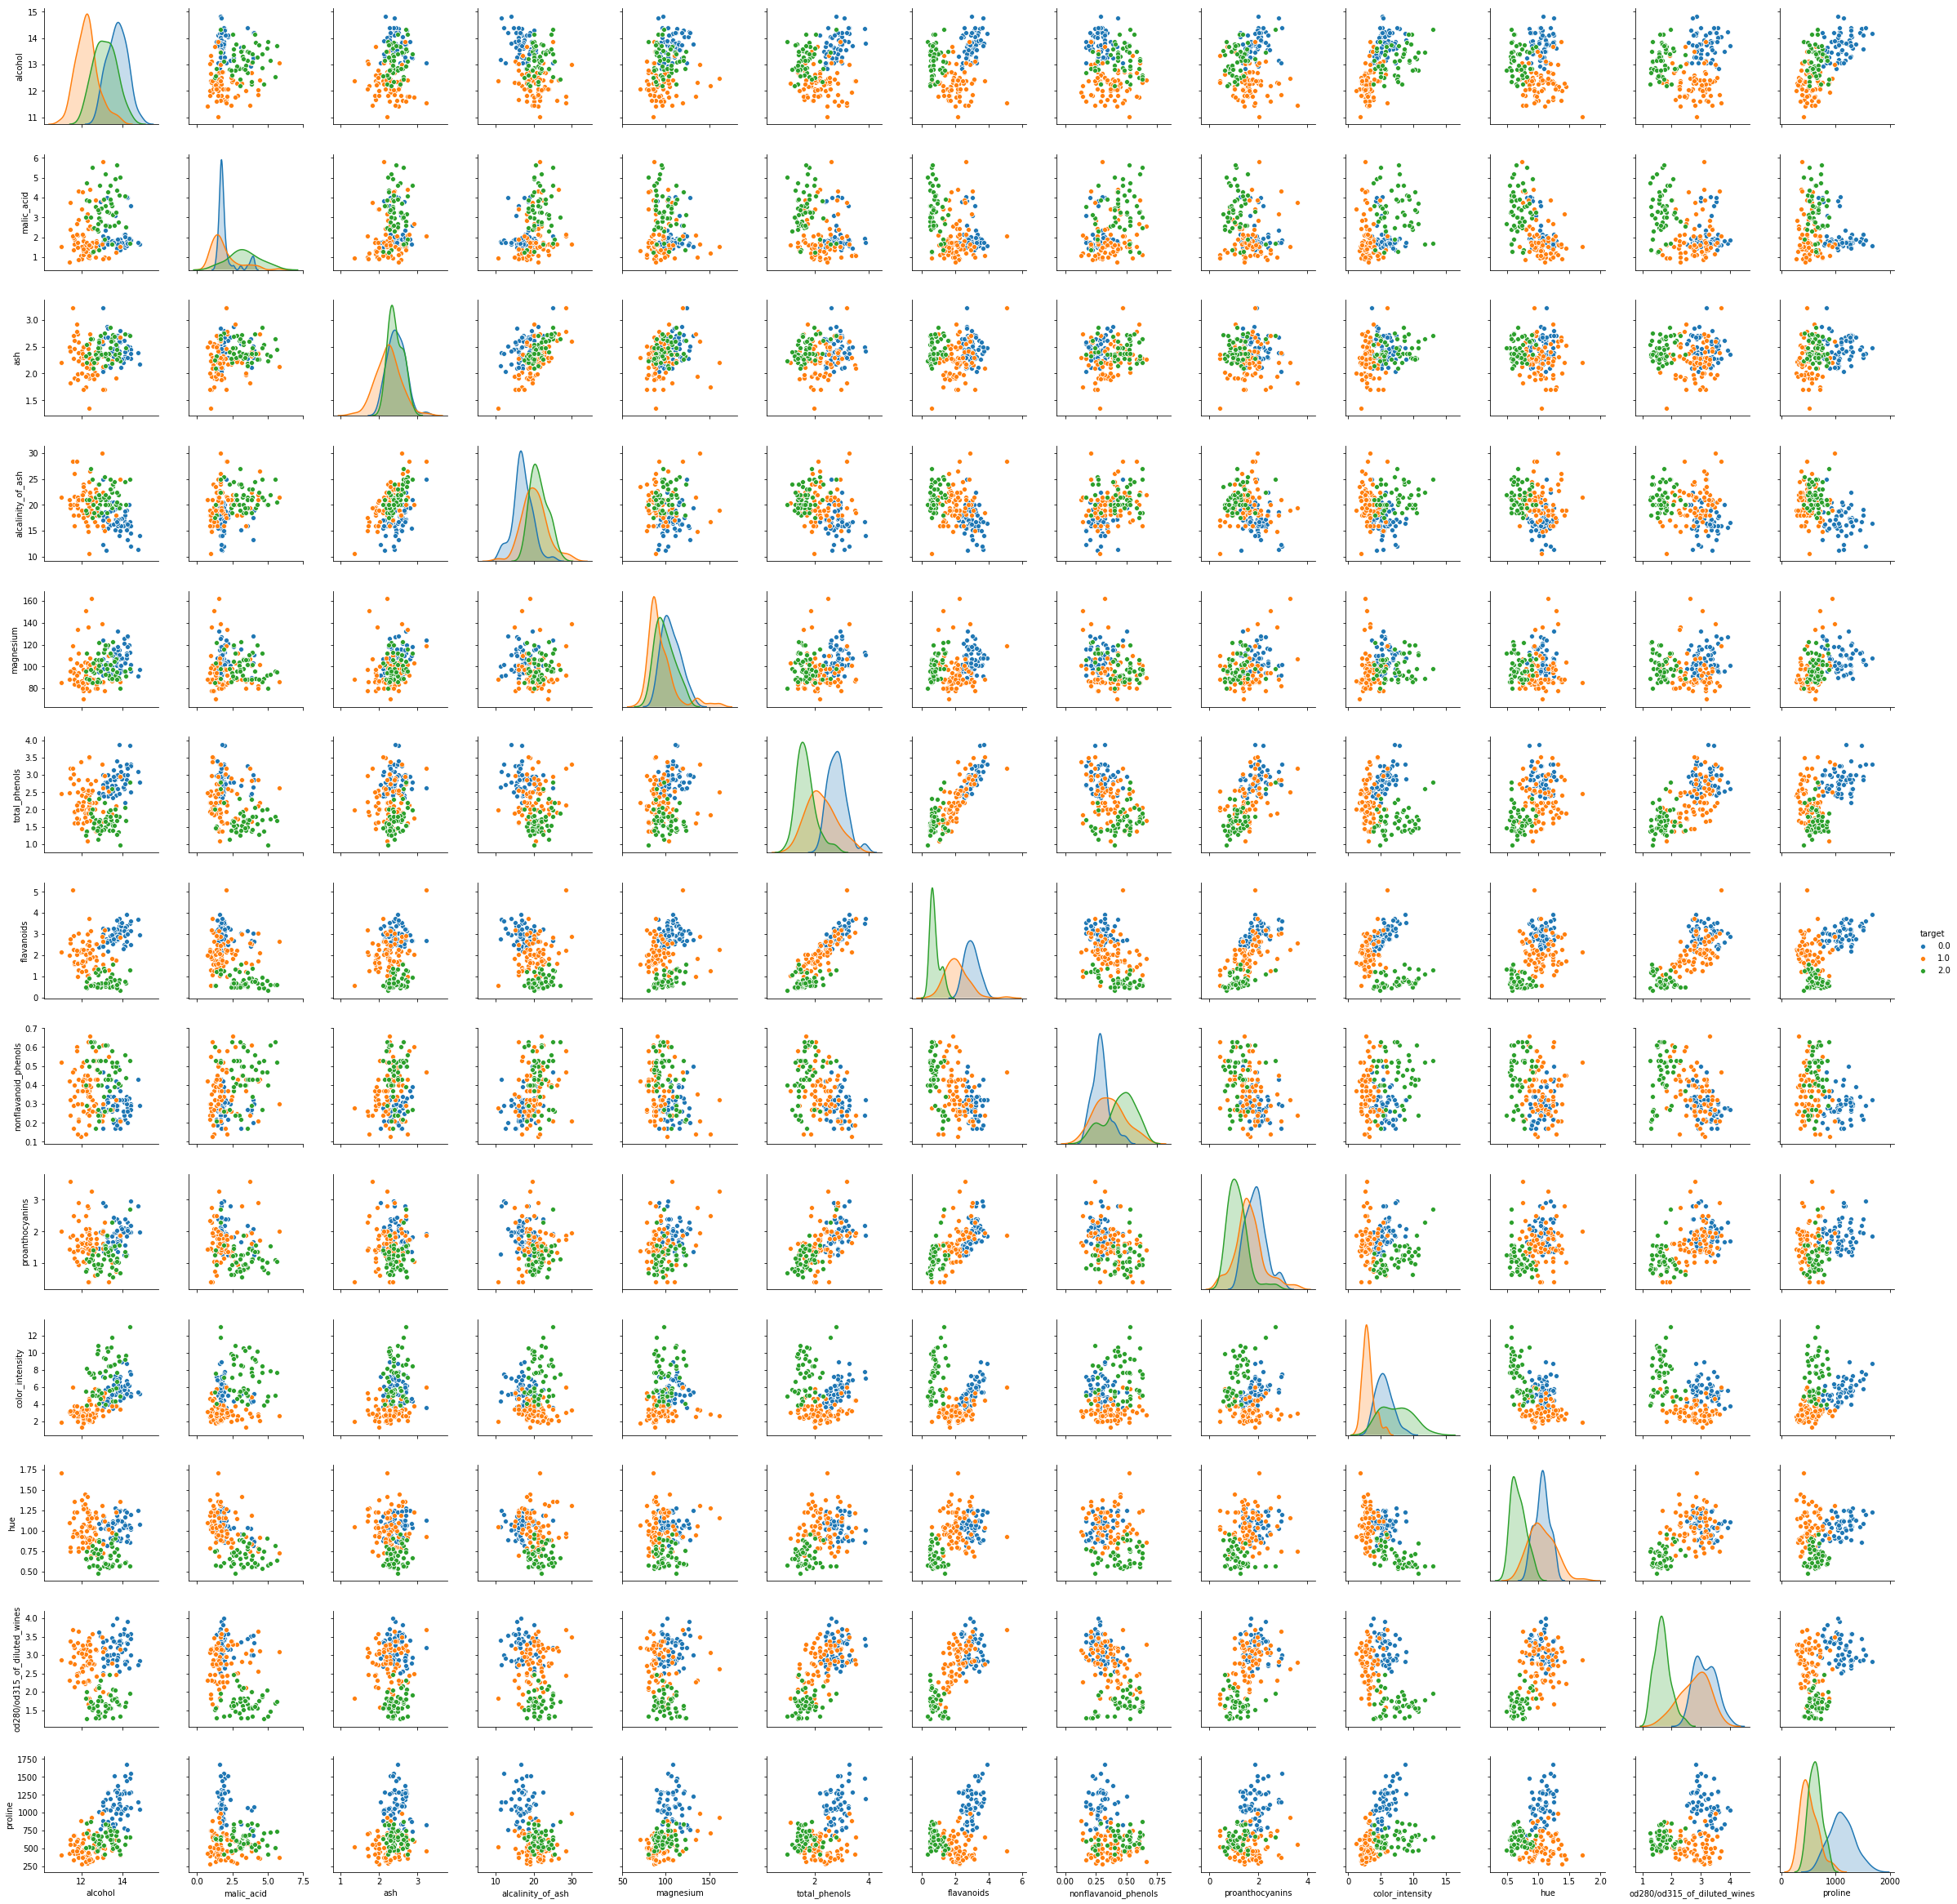

In [4]:
sns.pairplot(df, hue='target', vars=features)

Облачка в некоторых координатах очень хорошо различаются, но за всеми не уследишь...

Сразу возникает вопрос - что же значат эти классы? Тоесть верно ли что 1 > 2 > 3, или 1 > 2, но 2 < 3. Во втором случае никакая корреляция не поможет получить адекватные результаты(просто)

"It's likely these correspond to some typical wine varietals like Pinot Noir, or Cabernet, or Merlot..."

https://jonathonbechtel.com/blog/2018/02/06/wines/

Чтобы не усложнять будем предсказывать класс1, класс2, класс3 отдельно

In [5]:
target = df['target'].values
t_0 = np.zeros_like(target)
t_0[target == 0] = 1
t_1 = np.zeros_like(target)
t_1[target == 1] = 1
t_2 = np.zeros_like(target)
t_2[target == 2] = 1

Далее перебераем все возможные комбинации признаков, их много, но времени это займёт не так много

Посчитав корреляции с каждым классом посчитаем как `score` среднее квадратичное, т.к. когда мы всё это засунем в `LogisticRegression` то мы будем предсказывать всё в совокупности

In [38]:
feature_names = []
cors = []
for f_names in powerset(features):
    if f_names:
        x = df[list(f_names)].values
        corr_0 = get_mult_corr_p(x, t_0)
        corr_1 = get_mult_corr_p(x, t_1)
        corr_2 = get_mult_corr_p(x, t_2)
        feature_names.append(f_names)
        cors.append(np.sqrt((corr_0**2 + corr_1**2 + corr_2**2)/3))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [7]:
mult_corr_res = pd.DataFrame()
mult_corr_res['feature_names'] = feature_names
mult_corr_res['corr'] = cors
mult_corr_res['length'] = [len(fs) for fs in feature_names]

n = max(mult_corr_res['length'])
x = list(range(1, n+1))
mean = [np.mean(mult_corr_res[mult_corr_res['length']==i]['corr'].values) for i in x]
maxx = [np.max(mult_corr_res[mult_corr_res['length']==i]['corr'].values) for i in x]

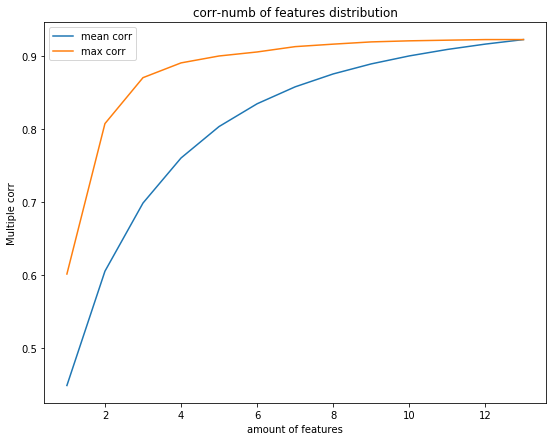

In [8]:
plt.figure(figsize=(9,7))
plt.plot(x, mean, label='mean corr')
plt.plot(x, maxx, label='max corr')
plt.xlabel('amount of features')
plt.ylabel('Multiple corr')
plt.title('corr-numb of features distribution')
plt.legend()
plt.show()

Вот перебрали мы все возможные комбинации, можем выделить подмножество с самой большой метрикой

In [9]:
mult_corr_res.sort_values('corr', inplace=True)
mult_corr_res['length'][-7:]

8182    12
8131    11
8134    11
8184    12
8181    12
8185    12
8190    13
Name: length, dtype: int64

Ну, наборы из почти всех метрик нас не интересуют, давайте ещё раз глянем на график и поймём, что в принципе 3-5 признаков окей, дальше не сильно изменяется

In [16]:
_mult_corr_res = mult_corr_res[mult_corr_res['length'] <= 5]
for s in _mult_corr_res['feature_names'][-3:].values:
    print(s)

('alcohol', 'ash', 'flavanoids', 'color_intensity', 'proline')
('alcohol', 'flavanoids', 'color_intensity', 'hue', 'proline')
('alcohol', 'malic_acid', 'flavanoids', 'color_intensity', 'proline')


Из знакомого только алкоголь. Чтож, теперь давайте проверим, адекватный ли это результат.

Для этого построим такой же график, только `score` теперь это не корреляция, а точность в регрессии

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['target']).values, df['target'].values,
                                                    stratify=target, test_size=0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
train_acc = []
test_acc = []
feature_names = []
%time
clf = LogisticRegression()
for f_names in powerset(features):
    if f_names:
        feature_names.append(f_names)
        
        _indexes = np.where(np.isin(features, f_names))[0]
        clf.fit(x_train[:, _indexes], y_train)
        
        train_acc.append(clf.score(x_train[:, _indexes], y_train))
        test_acc.append(clf.score(x_test[:, _indexes], y_test))

clf_res = pd.DataFrame()
clf_res['test_acc'] = test_acc
clf_res['train_acc'] = train_acc
clf_res['feature_names'] = feature_names
clf_res['length'] = [len(fs) for fs in clf_res['feature_names']]

In [13]:
n = max(clf_res['length'])
x = list(range(1, n+1))
test_mean_clf = [np.mean(clf_res[clf_res['length']==i]['test_acc'].values) for i in x]
test_maxx_clf = [np.max(clf_res[clf_res['length']==i]['test_acc'].values) for i in x]
train_mean_clf = [np.mean(clf_res[clf_res['length']==i]['train_acc'].values) for i in x]
train_maxx_clf = [np.max(clf_res[clf_res['length']==i]['train_acc'].values) for i in x]

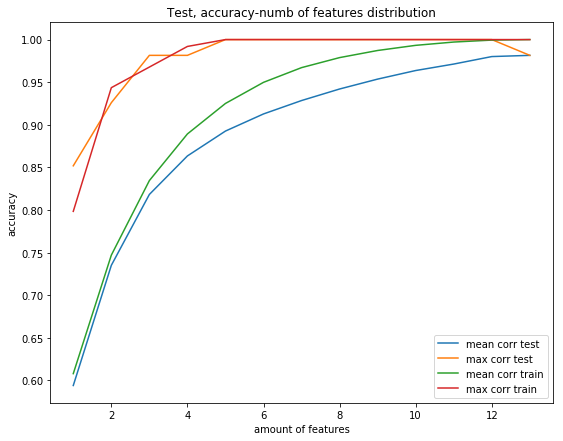

In [14]:
plt.figure(figsize=(9,7))
plt.plot(x, test_mean_clf, label='mean corr test')
plt.plot(x, test_maxx_clf, label='max corr test')
plt.plot(x, train_mean_clf, label='mean corr train')
plt.plot(x, train_maxx_clf, label='max corr train')
plt.xlabel('amount of features')
plt.ylabel('accuracy')
plt.title('Test, accuracy-numb of features distribution')
plt.legend()
plt.show()

Похожий график. А максимумы совпадают?

In [32]:
clf_res.sort_values('test_acc', inplace=True)
_clf_res = clf_res[clf_res['length'] <= 5]
print('It was')
for s in _mult_corr_res['feature_names'][-3:].values:
    print('\t',s)
    
print('It is')
for s in _clf_res['feature_names'][-3:].values:
    print('\t',s)

It was
	 ('alcohol', 'ash', 'flavanoids', 'color_intensity', 'proline')
	 ('alcohol', 'flavanoids', 'color_intensity', 'hue', 'proline')
	 ('alcohol', 'malic_acid', 'flavanoids', 'color_intensity', 'proline')
It is
	 ('malic_acid', 'alcalinity_of_ash', 'flavanoids', 'od280/od315_of_diluted_wines', 'proline')
	 ('alcohol', 'ash', 'flavanoids', 'hue', 'proline')
	 ('alcohol', 'total_phenols', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline')


Почти совпало, класс. Уточню сколько позиций совпало в каждой строке
- 2/5
- 4/5
- 3/5

Наверное это неплохо

Что будет если взять побольше признаков?

In [35]:
n_feat = 6
_mult_corr_res = mult_corr_res[mult_corr_res['length'] <= n_feat]
_clf_res = clf_res[clf_res['length'] <= n_feat]
print('It was')
for s in _mult_corr_res['feature_names'][-3:].values:
    print('\t',s)
    
print('It is')
for s in _clf_res['feature_names'][-3:].values:
    print('\t',s)

It was
	 ('alcohol', 'malic_acid', 'ash', 'flavanoids', 'color_intensity', 'proline')
	 ('alcohol', 'ash', 'flavanoids', 'color_intensity', 'hue', 'proline')
	 ('alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'proline')
It is
	 ('alcohol', 'ash', 'magnesium', 'flavanoids', 'hue', 'proline')
	 ('alcohol', 'magnesium', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline')
	 ('alcohol', 'total_phenols', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline')


Ничего хорошего не получается, чтоже, остановимся на предыдущем этапе, когда угодал 4/5 во 2ом по резльтативности варианте

## Вывод:

определили `feature importance`, быстрее чем сразу через перебор параметров для ререссии. Почти совпало